In [2]:
!pip install torchsummary

In [3]:
!pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.3 MB/s eta 0:00:00


In [4]:
! pip install mediapipe

  Obtaining dependency information for mediapipe from https://files.pythonhosted.org/packages/8a/83/6674d8f1a7cabb6a6a50defeb629c04e9b8b24798b5962c1075fed2c40a7/mediapipe-0.10.9-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 39.9 MB/s eta 0:00:00:00:0100:01


**Importing the required libraries**

In [5]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as tt
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import cv2
from PIL import Image

from pathlib import Path

In [6]:
DATA_ROOT = Path('/kaggle/input/leapgestrecog/leapGestRecog/')

**Let's save the class names by loading one of the folders:**

In [7]:
tmp_ds = ImageFolder(DATA_ROOT / '00')
CLASSES_NAME = tmp_ds.classes
CLASSES_NAME

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

**Let's set the transformations for the train and the test. For Grayscale, we set the number of output layers to 3, because resnet does not accept single channel images**

In [8]:
train_tfms = tt.Compose([
                         tt.Grayscale(num_output_channels=3), # Pictures black and white
                         tt.Resize([128, 128]),
                         # Settings for expanding the dataset
                         tt.RandomHorizontalFlip(),           
                         tt.RandomRotation(30),               
                         tt.ToTensor(),                      
                         ])                      

test_tfms = tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.Resize([128, 128]),
                        tt.ToTensor(),
                        ])
     

**Let's create training and test datasets with the same images, but with different preprocessing:**

In [9]:
train_ds_list = []
test_ds_list = []
for dir in os.listdir(DATA_ROOT):
    train_ds = ImageFolder(os.path.join(DATA_ROOT, dir), train_tfms)
    test_ds = ImageFolder(os.path.join(DATA_ROOT, dir), test_tfms)
    train_ds_list.append(train_ds)
    test_ds_list.append(test_ds)

train_ds = ConcatDataset(train_ds_list)
test_ds = ConcatDataset(test_ds_list)

**Total number of pictures:**

In [10]:
LEN_DS = len(train_ds)
LEN_DS

20000

**The function to convert the class number to its name:**

In [11]:
def digit_to_classname(digit):
    for idx, itm in enumerate(CLASSES_NAME):
        if idx == digit:
            return itm

**Let's look at the distribution of classes in the dataset:**

**This code first counts the number of samples in each class in the training set using the Counter class from the collections module. The Counter object is then used to create a bar plot showing the class distribution in the training set.**

**Similar code can be used to visualize the class distribution in the test set.**

In [12]:
# from collections import Counter

# train_counts = Counter([label for _, label in train_ds])
# print(train_counts)

# import matplotlib.pyplot as plt
# plt.bar(train_counts.keys(), train_counts.values())
# plt.xlabel('Class label')
# plt.ylabel('Number of samples')
# plt.title('Class distribution in training set')
# plt.show()

**Class distribution is equal.**

In [13]:
torch.manual_seed(1)

val_split = 0.2
split = int(LEN_DS * val_split)
indices = torch.randperm(LEN_DS)

train_ds = torch.utils.data.Subset(train_ds, indices[split:])
test_ds = torch.utils.data.Subset(test_ds, indices[:split])

len(train_ds), len(test_ds)

(16000, 4000)

**Let's check the dimension of the random tensor in the dataset:**

In [14]:
train_ds[15000][0].size()

torch.Size([3, 128, 128])

**Let's create dataloaders:**

In [15]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size, num_workers=1, shuffle=False)

**Let's display a random image in the test loader:**

torch.Size([3, 128, 128])
tensor(2) 03_fist


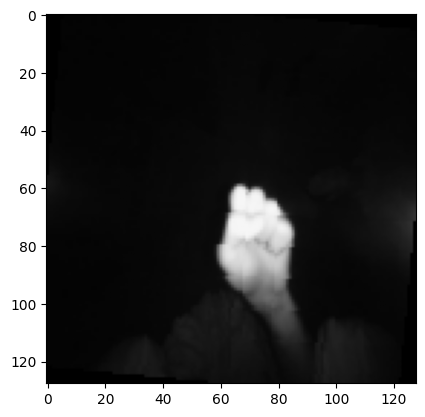

In [16]:
for img, l in train_dl:
    print(img[0].shape)
    print(l[0], digit_to_classname(l[0]))
    plt.imshow(img[0].permute(1, 2, 0)) #, cmap='gray')
    break

**Function for batch visualization:**

In [17]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([3, 128, 128])


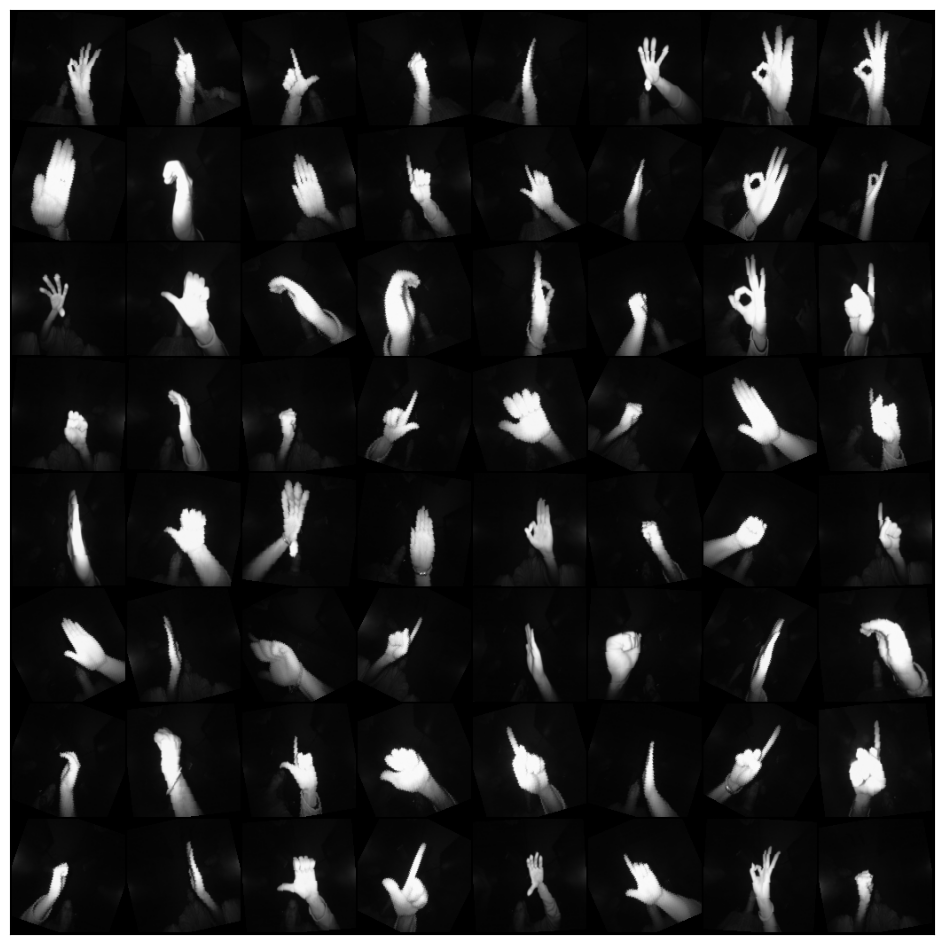

In [18]:
show_batch(train_dl)

**Let's define a device for the operation of neural networks:**

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

**Let's take a pre-trained network resnet50 for classification:**

In [20]:
resnet = models.resnet50(pretrained=True)
summary(resnet.to(device), input_size=(3, 128, 128))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.1MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [21]:
for param in resnet.parameters():
    param.requires_grad = False

**Forbid weights to learn**

**Let's overwrite the last classification layer, and make sure that the rest of the layers will not be trained:**

In [22]:
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=len(CLASSES_NAME))
resnet.fc = fc

summary(resnet.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

**Let's create a list of trainable parameters and feed it to the optimizer. We also initialize the loss function:**

In [23]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

        
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params_to_update, lr=0.001)


We initialize the function for training the network:

In [24]:
# from time import time
# print_every = 50
# num_epoch = 10

# # def train(model,
# #           criterion,
# #           optimizer,
# #           train_dataloader,
# #           test_dataloader,
# #           print_every,
# #           num_epoch):
# steps = 0
# train_losses, val_losses = [], []
    
# model=resnet
# criterion=criterion
# optimizer=optimizer
# train_dataloader=train_dl
# test_dataloader=test_dl
# print_every=print_every
# num_epoch=num_epoch
# model.to(device)

# for epoch in range(num_epoch):
#     running_loss = 0
#     correct_train = 0
#     total_train = 0
#     start_time = time()
#     iter_time = time()
        
#     model.train()
#     for i, (images, labels) in enumerate(train_dataloader):
#         steps += 1
#         images = images.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         output = model(images)
#         loss = criterion(output, labels)

#         correct_train += (torch.max(output, dim=1)[1] == labels).sum()
#         total_train += labels.size(0)

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#         # Logging
#         if steps % print_every == 0:
#             print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
#             print(f'Train loss {running_loss / steps:.3f}.', end=' ')
#             print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
#             with torch.no_grad():
#                 model.eval()
#                 correct_val, total_val = 0, 0
#                 val_loss = 0
#                 for images, labels in test_dataloader:
#                     images = images.to(device)
#                     labels = labels.to(device)
#                     output = model(images)
#                     loss = criterion(output, labels)
#                     val_loss += loss.item()

#                     correct_val += (torch.max(output, dim=1)[1] == labels).sum()
#                     total_val += labels.size(0)

#             print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
#             print(f'Took {time() - iter_time:.3f} seconds')
#             iter_time = time()

#             train_losses.append(running_loss / total_train)
#             val_losses.append(val_loss / total_val)


#     print(f'Epoch took {time() - start_time}') 
#     torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
        
# resnet, train_losses, val_losses = model, train_losses, val_losses

**Let's train the network on 10 epochs:**

**Save and download our model:**

In [25]:
torch.save(resnet, '/kaggle/working/my_model')

In [42]:
efficientnet = models.efficientnet_b0(pretrained=True)
summary(efficientnet.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              SiLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              SiLU-6           [-1, 32, 64, 64]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 16, 64, 64]             512
      BatchNorm2d-14           [-1, 16,

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
for param in efficientnet.parameters():
    param.requires_grad = False

In [47]:
efficientnet

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [48]:
# in_features = squeezenet.classifier.in_features
#in_features = efficientnet.classifier['Linear'].in_features
classifier = nn.Linear(in_features=1280, out_features=len(CLASSES_NAME))
efficientnet.classifier = classifier

summary(efficientnet.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              SiLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              SiLU-6           [-1, 32, 64, 64]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 16, 64, 64]             512
      BatchNorm2d-14           [-1, 16,

In [50]:
params_to_update = []
for name, param in efficientnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

        
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

In [51]:
from time import time

def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in range(num_epoch):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}') 
        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses

In [54]:
print_every = 50
num_epoch = 10

efficientnet, train_losses, val_losses = train(
    model=efficientnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=num_epoch
)

Epoch [1]/[10]. Batch [50]/[250]. Train loss 1.425. Train acc 59.625. Val loss 0.898. Val acc 79.475. Took 38.245 seconds
Epoch [1]/[10]. Batch [100]/[250]. Train loss 1.252. Train acc 65.078. Val loss 0.701. Val acc 84.075. Took 29.941 seconds
Epoch [1]/[10]. Batch [150]/[250]. Train loss 1.148. Train acc 68.021. Val loss 0.598. Val acc 86.600. Took 29.787 seconds
Epoch [1]/[10]. Batch [200]/[250]. Train loss 1.078. Train acc 69.586. Val loss 0.539. Val acc 87.150. Took 30.416 seconds
Epoch [1]/[10]. Batch [250]/[250]. Train loss 1.021. Train acc 71.037. Val loss 0.477. Val acc 89.175. Took 27.961 seconds
Epoch took 156.38736200332642
Epoch [2]/[10]. Batch [50]/[250]. Train loss 0.156. Train acc 71.344. Val loss 0.519. Val acc 86.425. Took 25.549 seconds
Epoch [2]/[10]. Batch [100]/[250]. Train loss 0.243. Train acc 74.875. Val loss 0.482. Val acc 87.900. Took 24.510 seconds
Epoch [2]/[10]. Batch [150]/[250]. Train loss 0.303. Train acc 76.167. Val loss 0.449. Val acc 88.650. Took 24.

**Let's see the predictions for 5 pictures from the test dataset:**

**Everything works great**